In [326]:
import pandas as pd
import numpy as np
import itertools
import sys
sys.path.insert(0,'../..')

import matplotlib.pyplot as plt

from g4l.data import Sample
import g4l.display
from g4l.tree import ContextTree

#cache_dir = '../example1/cache'

In [87]:
# Create a sample object instance
X = Sample('../example1/folha.txt', [0, 1, 2, 3, 4])
t = ContextTree(X, max_depth=4)

In [153]:
df = t.df.copy()
df['leaf'] = 0
max_node_length = df.l.max() # 4
# Eliminate nodes with no contribution
df = df[df.lps<0]
# Mark all last-level nodes as leaf
df.loc[df.l==max_node_length, 'leaf'] = 1

In [154]:
# for every node with child nodes, sum the log-likelihoods of the child nodes
leaves = df[df.leaf==1]
parent_idx = leaves.parent_idx.unique()[0]
sum_likelihood = df[df.parent_idx==parent_idx].lps.sum()
df.loc[df.node_idx==parent_idx, 'transition_sum_log_probs'] = sum_likelihood
df.loc[df.node_idx==parent_idx]

,l,node_idx,len_idx,parent_idx,node,node_freq,lps,transition_probs,transition_sum_log_probs,flag,final,leaf
30,3,30,0,5,000,3303,-1975.429579,"[0.28549803209203756, 0.7145019679079625, 0.0,...",-1952.177437,0,0,0


In [186]:
leaves = df[(df.leaf==1) & (df.flag==0)]
print('leaves:', len(leaves))
parents_idx = leaves.parent_idx.unique()
print('parents_idx:', len(parents_idx))
print(parents_idx)


leaves: 139
parents_idx: 51
[18 30 31 32 33 35 37 40 41 43 44 45 46 48 49 55 57 65 66 68 69 80 81 83
 85 87 95 99 100 101 103 105 106 108 110 112 120 121 123 124 125 126 128
 130 131 133 135 137 145 146 148]


In [187]:
parent_nodes = df[df.node_idx.isin(parents_idx) & (df.flag==0)].sort_values(['transition_sum_log_probs'], ascending=False)
print('Total parent nodes', len(parent_nodes))
parent_nodes.head(5)


Total parent nodes 51


,l,node_idx,len_idx,parent_idx,node,node_freq,lps,transition_probs,transition_sum_log_probs,flag,final,leaf
18,2,18,13,2,32,1640,-1131.761170,"[0.5390243902439025, 0.4609756097560976, 0.0, ...",-1.392405,0,0,0
40,3,40,10,7,020,8634,-5951.316544,"[0.4561037757702108, 0.5438962242297892, 0.0, ...",-1.394032,0,0,0
41,3,41,11,7,120,2757,-1896.661786,"[0.44903881030105186, 0.5509611896989481, 0.0,...",-1.396737,0,0,0
87,3,87,57,16,212,1628,-1119.551487,"[0.5522113022113022, 0.4477886977886978, 0.0, ...",-1.397258,0,0,0
100,3,100,70,19,042,997,-684.650247,"[0.5566700100300903, 0.44332998996990974, 0.0,...",-1.399224,0,0,0


In [188]:
# select the 'parent' node that is less contributive to the likelihood
node = parent_nodes.iloc[0]
node

l                                                                           2
node_idx                                                                   18
len_idx                                                                    13
parent_idx                                                                  2
node                                                                       32
node_freq                                                                1640
lps                                                                  -1131.76
transition_probs            [0.5390243902439025, 0.4609756097560976, 0.0, ...
transition_sum_log_probs                                              -1.3924
flag                                                                        0
final                                                                       0
leaf                                                                        0
Name: 18, dtype: object

In [189]:
# mark all leafs from this parent node as removed
df.loc[df.parent_idx==node.node_idx, 'flag'] = 1
df.loc[df.parent_idx==node.node_idx]


,l,node_idx,len_idx,parent_idx,node,node_freq,lps,transition_probs,transition_sum_log_probs,flag,final,leaf
95,3,95,65,18,032,999,-682.752417,"[0.5695695695695696, 0.43043043043043044, 0.0,...",-1.405844,1,0,0
96,3,96,66,18,132,316,-218.629273,"[0.5253164556962026, 0.47468354430379744, 0.0,...",-1.388861,1,0,1
98,3,98,68,18,332,175,-121.297899,"[0.49714285714285716, 0.5028571428571429, 0.0,...",-1.386327,1,0,1
99,3,99,69,18,432,150,-101.707323,"[0.41333333333333333, 0.5866666666666667, 0.0,...",-1.416799,1,0,0


In [190]:
# consider this parent node as a leaf node henceforth
df.loc[df.node_idx==node.node_idx, 'leaf'] = 1
df.loc[df.node_idx==node.node_idx]


,l,node_idx,len_idx,parent_idx,node,node_freq,lps,transition_probs,transition_sum_log_probs,flag,final,leaf
18,2,18,13,2,32,1640,-1131.76117,"[0.5390243902439025, 0.4609756097560976, 0.0, ...",-1.392405,0,0,1


### Iterating until the root node and registering results

In [402]:
# Initializing for iteration
df2 = pd.DataFrame(columns=['num_contexts', 'likelihood', 'tree'])
df = t.df.copy()
df['leaf'] = 0
max_node_length = df.l.max() # 4
df = df[df.node_freq>0]
df.loc[df.l==max_node_length, 'leaf'] = 1

In [403]:
# Precompute sum of likelihoods
leaves = df[df.leaf==1]
parent_idx = leaves.parent_idx.unique()[0]
sum_likelihood = df[df.parent_idx==parent_idx].lps.sum()
df.loc[df.node_idx==parent_idx, 'transition_sum_log_probs'] = sum_likelihood

In [404]:
# Iterate
while True:
    leaves = df[(df.leaf==1) & (df.flag==0)]
    parent_nodes = df[df.node_idx.isin(leaves.parent_idx.unique()) & (df.flag==0)]
    parent_nodes = parent_nodes.sort_values(['transition_sum_log_probs'], ascending=False)
    if len(parent_nodes)==0:
        break    
    #print(len(leaves), len(parent_nodes))
    current_node_idx = list(parent_nodes.node_idx)[0]    
    r1 = len(df[df.flag==0])
    df.loc[(df.parent_idx==current_node_idx), 'flag'] = 1
    r2 = len(df[df.flag==0])
    #print(r1, r2)
    df.loc[df.node_idx==current_node_idx, 'leaf'] = 1
    #df.loc[df.node_idx==current_node_idx, 'flag'] = 0
    #df.loc[df.node_idx==current_node_idx]
    likelihood = df[df.flag==0].lps.sum()
    row = [len(leaves), likelihood, '']
    #print(row)
    df2.loc[len(df2)] = row

In [405]:
#leaves = df[(df.leaf==1) & (df.flag==0)]
#df[df.node_idx.isin(leaves.parent_idx.unique())]
#parent_nodes = df[df.node_idx.isin(leaves.parent_idx.unique()) & (df.flag==0)].sort_values(['transition_sum_log_probs'], ascending=False)
#parent_nodes

In [406]:
#with pd.option_context('display.max_rows', 8):
#    print(df2)
df

,l,node_idx,len_idx,parent_idx,node,node_freq,lps,transition_probs,transition_sum_log_probs,flag,final,leaf
0,1,0,0,None,0,44111,-62840.152905,"[0.23846659563374215, 0.29559520301058695, 0.3...",-9.367255,0,0,1
1,1,1,1,None,1,21830,-18794.382713,"[0.6933577645442052, 0.0, 0.20998625744388455,...",-8.296834,0,0,1
2,1,2,2,None,2,21830,-14715.435172,"[0.5972972972972973, 0.4027027027027027, 0.0, ...",-1.424897,0,0,1
3,1,3,3,None,3,7909,-6671.568838,"[0.6849159185737768, 0.0, 0.2073587052724744, ...",-9.670055,0,0,1
4,1,4,4,None,4,2070,-1325.580428,"[0.0, 0.0, 0.6608695652173913, 0.3381642512077...",-1.498422,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
733,4,733,578,145,3034,6,-4.158883,"[0.0, 0.0, 0.5, 0.5, 0.0]",-1.386294,1,0,1
735,4,735,580,146,0134,4,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0]",0.000000,1,0,1
737,4,737,582,146,2134,8,-5.292506,"[0.0, 0.0, 0.625, 0.375, 0.0]",-1.450833,1,0,1
745,4,745,590,148,0334,2,-1.386294,"[0.0, 0.0, 0.5, 0.5, 0.0]",-1.386294,1,0,1


Num contexts: 75
Likelihood: -155697.01200514488


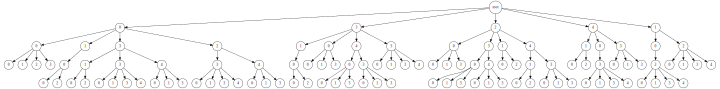

In [407]:
new_tree = ContextTree(X, max_depth=4, source_data_frame=df[df.flag==0].copy())
print("Num contexts:", new_tree.num_contexts())
print("Likelihood:", new_tree.log_likelihood())
g4l.display.draw_tree(new_tree.to_str())

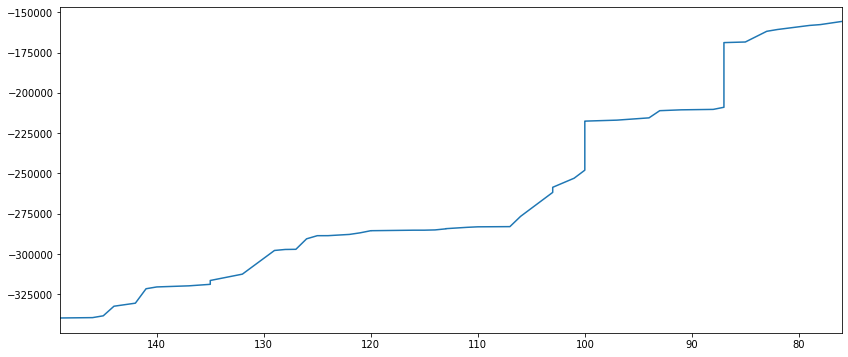

In [408]:
plt.figure(figsize=(14, 6))
plt.plot(df2.num_contexts, df2.likelihood)
plt.xlim(df2.num_contexts.max(), df2.num_contexts.min())
plt.show()

In [ ]:
x = t.df
x = x.sort_values(['node_freq'], ascending=False)
x = x.groupby(['node_freq']).median()
plt.figure(figsize=(14, 6))
plt.plot(x.lps)
#plt.xscale('log')
plt.show()
x.index